<a href="https://colab.research.google.com/github/prav1807/vehicle-routing-problem/blob/manualParameterTuningFileUpload/manualParameterTuningFileUpload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [147]:
# ----------------- Flexible File Loading -----------------

def load_file(file_path):

    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)  # Uses Pandas for CSV
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)  # Uses Pandas for Excel
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)  # Uses Pandas for JSON
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)  # Uses custom parser for VRP
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

In [148]:
# ----------------- Custom VRP Parser -----------------

def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1  # Convert to 0-based index

    return coordinates, demands, depot, vehicle_capacity

In [149]:
# ----------------- Problem Definition -----------------

# Load the dataset (can handle CSV, Excel, JSON, or VRP files)
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

# If using a VRP file, it returns the necessary components
if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Parameters -----------------

num_ants = 30          # Number of ants per iteration
num_iterations = 100   # Number of iterations
alpha = 0.5            # Pheromone influence
beta = 2.0             # Distance influence
evaporation_rate = 0.3 # Pheromone evaporation rate
pheromone_constant = 50  # Pheromone deposit factor
num_vehicles = 5       # Number of vehicles based on dataset


In [150]:
# ----------------- Distance Calculation -----------------

# Calculate distance matrix
def calculate_distance_matrix(customers):
    num_customers = len(customers)
    distance_matrix = np.zeros((num_customers, num_customers))
    for i in customers:
        for j in customers:
            if i != j:
                xi, yi = customers[i]
                xj, yj = customers[j]
                distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)
                distance_matrix[i][j] = distance
            else:
                distance_matrix[i][j] = 0
    return distance_matrix

distance_matrix = calculate_distance_matrix(customers)

# Initialize pheromone matrix
num_customers = len(customers)
pheromone_matrix = np.ones((num_customers, num_customers))  # Initial pheromone

In [151]:
# ----------------- ACO Functions -----------------

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]  # Start from depot
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                # No more customers can be added to this route
                route.append(depot)  # Return to depot
                break

            # Normalize probabilities
            total = sum(probabilities)
            if total == 0:
                # Avoid division by zero
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            # Select next customer based on probability distribution
            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    # Check if all customers are visited
    all_visited = True
    for customer in customers:
        if customer not in [c for route in routes for c in route]:
            all_visited = False
            break

    if not all_visited:
        # If not all customers are visited, assign remaining to any vehicle that can take them
        for customer in customers:
            if customer not in [c for route in routes for c in route]:
                for route in routes:
                    # Check capacity
                    current_load = sum([demands[c] for c in route if c != depot])
                    if current_load + demands[customer] <= vehicle_capacity:
                        # Insert before returning to depot
                        route.insert(-1, customer)
                        break

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    # Evaporate pheromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Add pheromones based on solutions
    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

In [152]:
# ----------------------- Visualising the Customer and Depot ----------------
def plot_customers(customers, routes=None):
    plt.figure(figsize=(10, 8))
    for customer, (x, y) in customers.items():
        if customer == depot:
            plt.scatter(x, y, c='red', marker='s', s=100, label='Depot')
            plt.text(x + 1, y + 1, f'Depot ({customer})')
        else:
            plt.scatter(x, y, c='blue', marker='o', s=50)
            plt.text(x + 1, y + 1, f'{customer}')

    if routes:
        colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for idx, route in enumerate(routes):
            route_coords = [customers[customer] for customer in route]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors[idx % len(colors)], label=f'Vehicle {idx+1}')

    plt.title('Customer Locations and Depot')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [153]:
# ----------------- ACO Algorithm -----------------

best_routes = None
best_distance = float('inf')

for iteration in range(num_iterations):
    ants_solutions = []
    iteration_best_distance = float('inf')
    iteration_best_routes = None

    for _ in range(num_ants):
        solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
        ants_solutions.append(solution)

        # Calculate total distance
        total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

        # Update best solution
        if total_distance < best_distance:
            best_distance = total_distance
            best_routes = solution

        # Track the best solution in this iteration
        if total_distance < iteration_best_distance:
            iteration_best_distance = total_distance
            iteration_best_routes = solution

    # Update pheromones based on all ants' solutions
    update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

    # Optional: Print iteration details
    print(f"Iteration {iteration+1}: Best Distance = {iteration_best_distance:.2f}")

Iteration 1: Best Distance = 1142.90
Iteration 2: Best Distance = 1208.95
Iteration 3: Best Distance = 1211.44
Iteration 4: Best Distance = 1139.57
Iteration 5: Best Distance = 1270.00
Iteration 6: Best Distance = 1046.40
Iteration 7: Best Distance = 1235.96
Iteration 8: Best Distance = 1193.39
Iteration 9: Best Distance = 1131.88
Iteration 10: Best Distance = 1122.33
Iteration 11: Best Distance = 1206.58
Iteration 12: Best Distance = 1140.45
Iteration 13: Best Distance = 1171.16
Iteration 14: Best Distance = 879.67
Iteration 15: Best Distance = 1161.09
Iteration 16: Best Distance = 938.29
Iteration 17: Best Distance = 1134.30
Iteration 18: Best Distance = 1128.21
Iteration 19: Best Distance = 1196.49
Iteration 20: Best Distance = 1109.24
Iteration 21: Best Distance = 1211.66
Iteration 22: Best Distance = 1176.68
Iteration 23: Best Distance = 1141.13
Iteration 24: Best Distance = 1055.10
Iteration 25: Best Distance = 1036.29
Iteration 26: Best Distance = 1005.71
Iteration 27: Best Dist


Best Route Found:
Vehicle 1: [0, 30, 12, 1, 7, 14, 24, 26, 18, 0]
  Distance: 248.55
Vehicle 2: [0, 24, 14, 27, 12, 16, 30, 0]
  Distance: 119.21
Vehicle 3: [0, 30, 14, 24, 27, 16, 1, 26, 0]
  Distance: 138.35
Vehicle 4: [0, 24, 14, 27, 30, 16, 12, 0]
  Distance: 116.80
Vehicle 5: [0, 14, 24, 27, 26, 16, 30, 1, 0]
  Distance: 137.78
Total Distance: 760.70


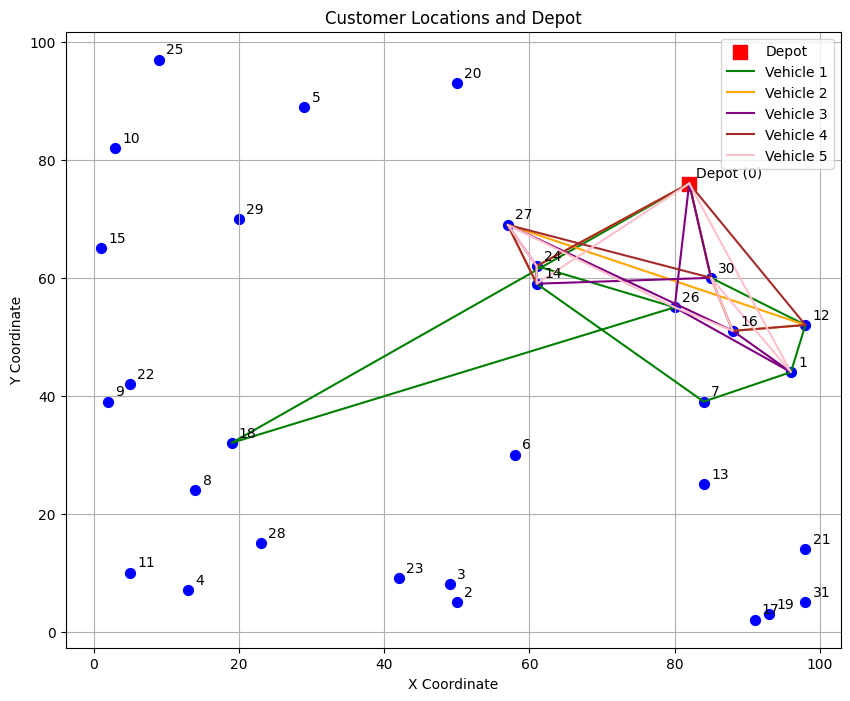

In [154]:
# ----------------- Results -----------------

print("\nBest Route Found:")
total_distance = 0
for idx, route in enumerate(best_routes):
    print(f"Vehicle {idx+1}: {route}")
    route_distance = calculate_route_length(route, distance_matrix)
    print(f"  Distance: {route_distance:.2f}")
    total_distance += route_distance
print(f"Total Distance: {total_distance:.2f}")

# Plot the best routes
plot_customers(customers, best_routes)